In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
# import hssm
import os
import arviz as az 
import pymc as pm
# hssm.set_floatX("float32")
random_seed = 10
from utils import *

## Read data

In [2]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)
comb_data = comb_data.loc[comb_data['rt'] < 10].reset_index(drop = True)
comb_data = comb_data.loc[comb_data['rt'] > 0.1].reset_index(drop = True)

comb_data['bumps_'] = '0_noisy'
comb_data.loc[comb_data['bumps'] == 'single', 'bumps_'] = '1_single'
comb_data.loc[comb_data['bumps'] == 'center', 'bumps_'] = '1_center'
comb_data['participant_id'] = comb_data['participant']


## Non Hierarchical Linear Modeling

### Single Parameter Models

In [3]:
single_param_models = ['diff_dir', 'means', 'direction', 'bumps', 'difference', 'cond']

In [4]:
def single_param_model_fits(single_param_models, dv = 'accuracy', family = 'bernoulli', data = comb_data):
    model_single_param_samples = {}
    for param in single_param_models:
        print('Fittting param: ', param)
        models_oneparam_nh = bmb.Model(f'{dv}~{param}', data = comb_data, family= family)
        models_oneparam_nh.build()
        model_single_param_samples[param] = models_oneparam_nh.fit(idata_kwargs={"log_likelihood": True})
        
    return model_single_param_samples

### All parameter models

#### Additive model

In [5]:
def additive_model_fit(dv = 'accuracy', family = 'bernoulli', data = comb_data):
    allparam_nh = bmb.Model(f'{dv}~ C(diff_dir) + means + C(direction) + C(bumps) + difference + cond', 
    data = comb_data, family=family)
    allparam_nh.build()
    # allparam_nh.graph()
    allparam_nh_samples = allparam_nh.fit(idata_kwargs={"log_likelihood": True})
    return allparam_nh_samples


#### Models with interaction

In [4]:
def models_with_interaction_fits(dv = 'accuracy', family = 'bernoulli', data = comb_data, formula_rhs = 'C(diff_dir) + means + C(direction) + difference + C(bumps_)*C(cond)'):
    allparam_interaction_nh = bmb.Model(f'{dv} ~ {formula_rhs}', 
    data = data, family=family)
    allparam_interaction_nh.build()
    # allparam_interaction_nh.graph()
    allparam_interaction_nh_samples = allparam_interaction_nh.fit(idata_kwargs={"log_likelihood": True})
    return allparam_interaction_nh_samples


## Run, Collect and Save Models for Accuracy

In [5]:
model_comp_dict = {}
# model_comp_dict = single_param_model_fits(single_param_models)
# model_comp_dict['model_allparam_additive'] = additive_model_fit()
model_comp_dict['model_allparam_bumps_cond_interaction'] = models_with_interaction_fits()


Modeling the probability that accuracy==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(diff_dir), means, C(direction), difference, C(bumps_), C(cond), C(bumps_):C(cond)]


ValueError: Not enough samples to build a trace.

In [9]:
# model_comp_dict = model_single_param_samples
# model_comp_dict['model_allparam_additive'] = allparam_nh_samples
# model_comp_dict['model_allparam_interaction'] = allparam_interaction_nh_samples


In [11]:
az.to_netcdf(model_comp_dict['model_allparam_bumps_cond_interaction'], f'modeling_results/linear_modeling_results/Accuracy/all_params_interaction')

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\tejas\\Documents\\Research\\verbal_visual_estimations\\analyses\\datavis_05\\modeling_results\\linear_modeling_results\\Accuracy\\all_params_interaction'

In [7]:
#Save
for key in model_comp_dict.keys():
    az.to_netcdf(model_comp_dict[key], f'modeling_results/linear_modeling_results/Accuracy/{key}')

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\tejas\\Documents\\Research\\verbal_visual_estimations\\analyses\\datavis_05\\modeling_results\\linear_modeling_results\\Accuracy\\model_allparam_interaction'

## Model Comparisons

In [12]:
az.compare(model_comp_dict)

/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_allparam_interaction,0,-6830.878095,12.992341,0.000000,9.557917e-01,45.637291,0.000000,False,log
model_allparam_additive,1,-6912.459631,9.043347,81.581536,9.935356e-15,44.534465,13.255293,False,log
cond,2,-6937.338172,2.998909,106.460077,3.045280e-02,44.047577,15.560632,False,log
bumps,3,-7066.485619,3.034676,235.607524,2.630019e-15,42.212593,21.577463,False,log
diff_dir,4,-7068.775926,1.986619,237.897831,3.831027e-15,42.169984,21.664082,False,log
difference,5,-7069.090824,2.001224,238.212729,3.175664e-15,42.171283,21.678956,False,log
direction,6,-7079.299280,1.944458,248.421185,5.281739e-15,41.982676,22.162554,False,log
means,7,-7080.001292,2.041033,249.123197,1.375555e-02,41.995653,22.288514,False,log


## Run Collect and save models for RTs

In [26]:
# model_comp_dict = single_param_model_fits(single_param_models, dv='rt', family='gaussian')
# model_comp_dict['model_allparam_additive'] = additive_model_fit(dv='rt', family='gaussian')
model_comp_dict['model_allparam_interaction'] = models_with_interaction_fits(dv='rt', family='gaussian')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rt_sigma, Intercept, C(diff_dir), means, C(direction), difference, C(bumps), C(cond), C(bumps):C(cond)]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [27]:
#Save
for key in model_comp_dict.keys():
    az.to_netcdf(model_comp_dict[key], f'modeling_results/linear_modeling_results/RT/{key}')

In [29]:
az.compare(model_comp_dict)

/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/work/tsavalia_umass

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_allparam_interaction,0,-34401.477541,305.621357,0.000000,0.125,2544.088318,0.000000,True,log
model_allparam_additive,1,-34429.289580,313.419959,27.812039,0.125,2545.973697,8.273090,True,log
direction,2,-34438.327128,282.958617,36.849587,0.125,2529.724035,18.399036,True,log
means,3,-34441.854199,299.613815,40.376658,0.125,2530.689221,18.058040,True,log
cond,4,-34444.276886,295.562626,42.799345,0.125,2543.879855,12.086711,True,log
difference,5,-34452.510369,302.599421,51.032828,0.125,2536.445813,15.271573,True,log
bumps,6,-34455.472811,330.667303,53.995271,0.125,2552.337225,12.745620,True,log
diff_dir,7,-34462.903540,348.903051,61.425999,0.125,2544.948634,13.523648,True,log


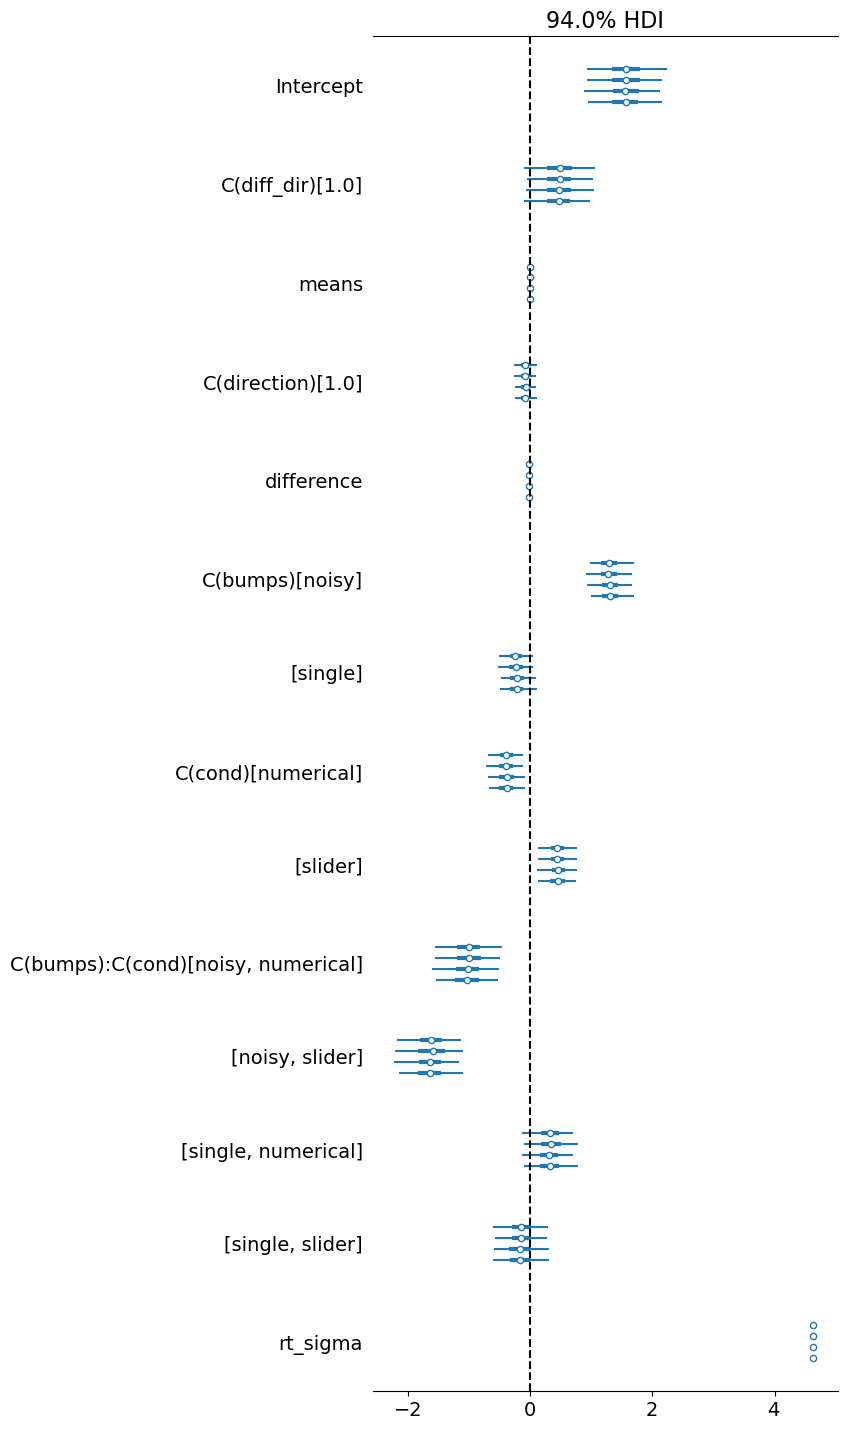

In [30]:
az.plot_forest(model_comp_dict['model_allparam_interaction'])
plt.axvline(0, ls = '--', color = 'black')

In [32]:
comb_data

,participant,means,direction,bumps,diff_dir,trials.thisN,difference,incorrect choice,key_resp,rt,cond,accuracy,response
0,25353.0,64.0,1.0,single,1.0,0.0,8.0,left,left,3.881548,chart,False,-1
1,25353.0,48.0,1.0,noisy,-1.0,1.0,-6.0,right,right,7.387671,chart,False,-1
2,25353.0,53.0,1.0,noisy,-1.0,2.0,-10.0,left,right,6.337773,chart,True,1
3,25353.0,64.0,-1.0,center,-1.0,3.0,-8.0,left,right,3.151569,chart,True,1
4,25353.0,60.0,1.0,center,1.0,4.0,8.0,left,right,5.806216,chart,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,908388.0,60.0,1.0,noisy,-1.0,285.0,-8.0,left,left,2.442362,chart,False,-1
11596,908388.0,49.0,1.0,single,-1.0,286.0,-12.0,right,left,0.798230,chart,True,1
11597,908388.0,38.0,-1.0,single,-1.0,287.0,-11.0,left,right,0.681007,chart,True,1
11598,908388.0,62.0,-1.0,center,-1.0,288.0,-12.0,right,left,0.802785,chart,True,1


# Read saved modeling results

In [9]:
# model_with_interaction = az.from_netcdf('modeling_results/linear_modeling_results/model_allparam_interaction')

model_with_interaction = model_comp_dict['model_allparam_interaction']

In [10]:
accuracy_stats = az.summary(model_with_interaction, stat_focus='mean', kind = 'stats', hdi_prob=.95)
accuracy_stats.to_latex('accuracy_stats_table')

C:\Users\tejas\AppData\Local\Temp\ipykernel_24896\3749378450.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  accuracy_stats.to_latex('accuracy_stats_table')


In [11]:
# accuracy_stats_tex

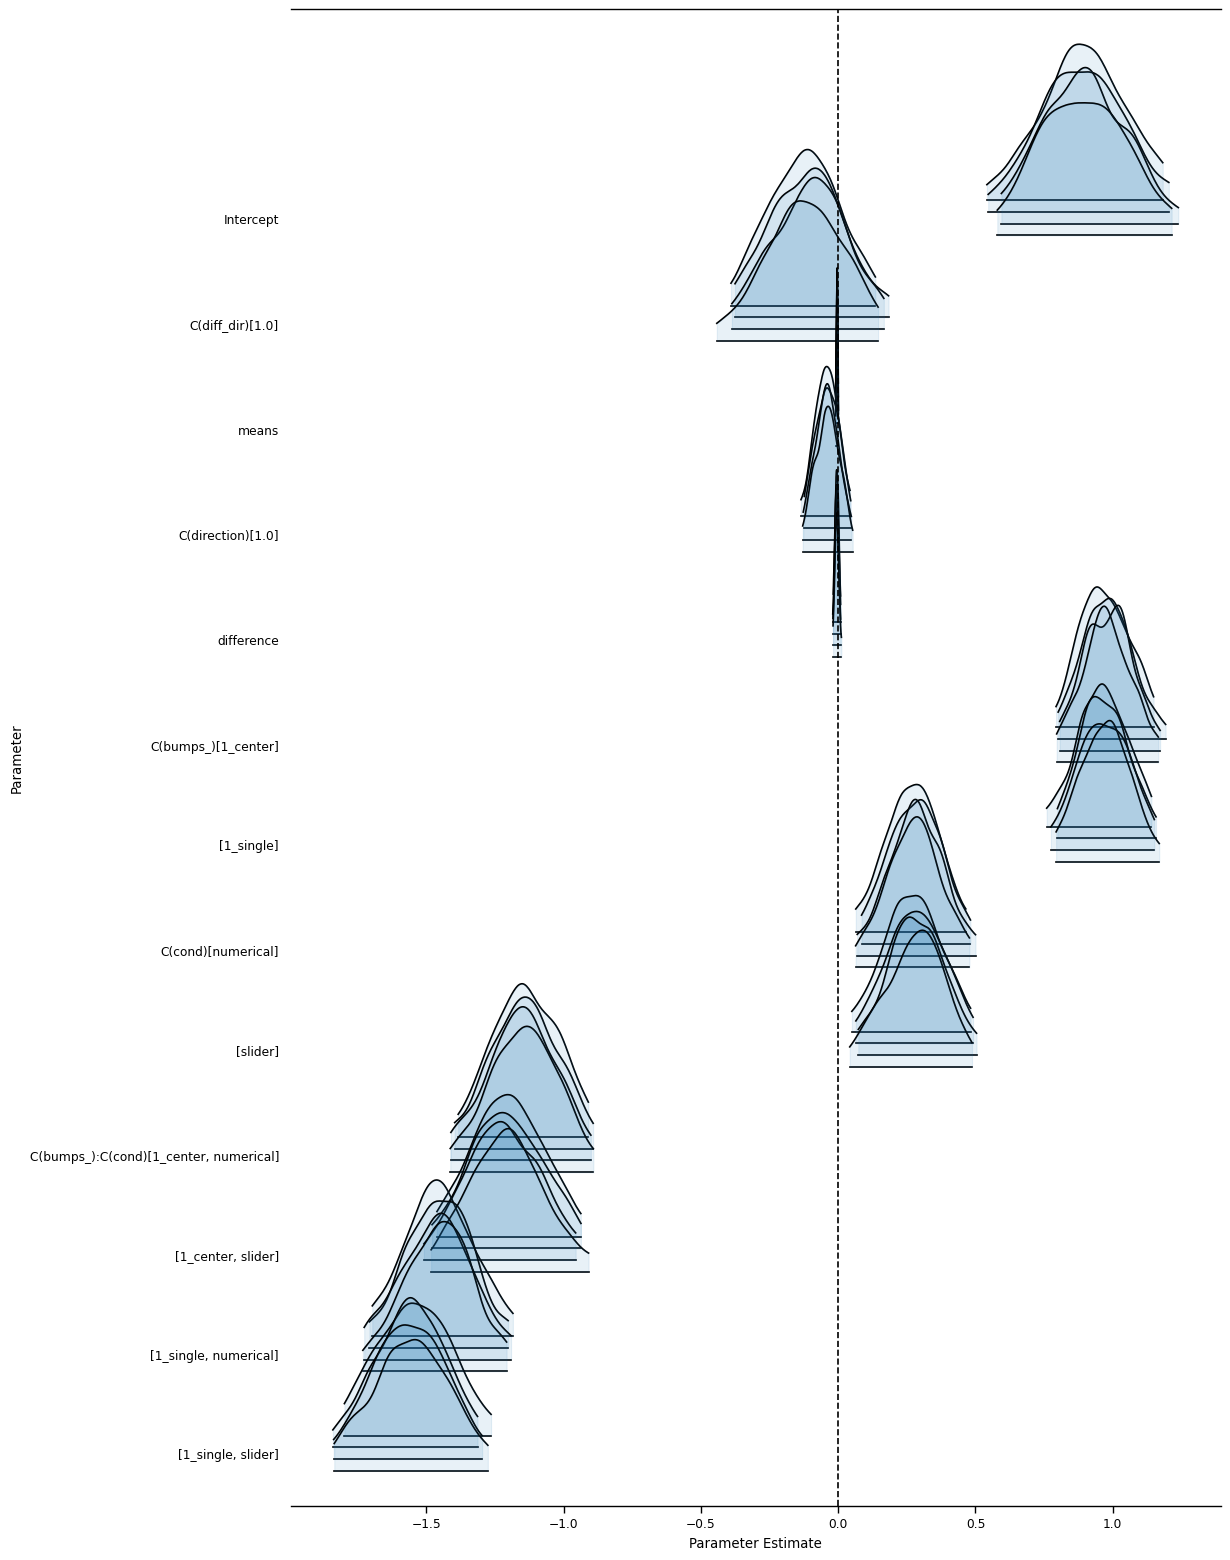

In [12]:
sns.set_context('paper')
az.plot_forest(model_with_interaction, hdi_prob=.95, kind='ridgeplot', ridgeplot_alpha=0.1)
plt.axvline(0, ls = '--', color = 'black')
plt.ylabel('Parameter')
plt.xlabel('Parameter Estimate')
plt.savefig('figures/accuracy_ridgeplot.png', dpi = 300, transparent = True)